# Исследование окупаемости рекламы приложения

### Краткое описание исследования

Мы проводим исследование развлекательного приложения Procrastinate Pro+. Компания осуществляет огромные вложения в рекламу, но последние несколько месяцев терпит убытки.\
Задача — разобраться в причинах не окупаемости расходов на привлечение пользователей.\
Мы исследуем данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.


**Цель исследования:**
1. определить рекламные каналы, через которые приходят пользователи, и какими устройствами они пользуются,
2. проанализировать окупаемость рекламы в разрезе стран, устройств и рекламных каналов,
3. выявить страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы,
4. выявить факторы, которые мешают привлечению клиентов,
5. дать рекомендации компании для получения прибыли.

**Описание данных:**\
Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.\

Структура `visits_info_short.csv`:\
*User Id* — уникальный идентификатор пользователя,\
*Region* — страна пользователя,\
*Device* — тип устройства пользователя,\
*Channel* — идентификатор источника перехода,\
*Session Start* — дата и время начала сессии,\
*Session End* — дата и время окончания сессии.

Структура `orders_info_short.csv`:\
*User Id* — уникальный идентификатор пользователя,\
*Event Dt* — дата и время покупки,\
*Revenue* — сумма заказа.

Структура `costs_info_short.csv`:\
*dt* — дата проведения рекламной кампании,\
*Channel* — идентификатор рекламного источника,\
*costs* — расходы на эту кампанию.

**Ход исследования:**
1. изучение данных о визитах, заказах и рекламных расходах из CSV-файлов и и выполнить их предобработку,
2. составление профили пользователей,
3. определение стран, из которых пользователи приходят в приложение, и страну с наибольшей долей платящих пользователей,
4. узнать какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи,
5. изучение рекламных источников привлечения и определение каналов, из которых пришло больше всего платящих пользователей,
6. анализ расходов компании на каждый рекламный источник,
7. анализ средней стоимости привлечения одного пользователя (CAC) из каждого источника,
8. анализ окупаемости рекламы, с использованием графиков LTV, ROI и CAC,
9. выделение причин неэффективности привлечения пользователей,
10. формулировка рекомендаций для отдела маркетинга.

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
visits_info = pd.read_csv('/datasets/visits_info_short.csv')

In [3]:
orders_info = pd.read_csv('/datasets/orders_info_short.csv')

In [4]:
costs_info = pd.read_csv('/datasets/costs_info_short.csv')

In [5]:
visits_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [6]:
orders_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [7]:
costs_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


#### Приведение наименования столбцов к нижнему регистру

In [8]:
# переименуем столбцы visits_info
visits_info.columns = [x.lower().replace(' ', '_') for x in visits_info.columns.values]

In [9]:
# переименуем столбцы orders_info
orders_info.columns = [x.lower().replace(' ', '_') for x in orders_info.columns.values]

In [10]:
# переименуем столбцы costs_info
costs_info.columns = [x.lower().replace(' ', '_') for x in costs_info.columns.values]

#### Преобразование данных о времени к типу datetime

In [11]:
# преобразование данных о времени visits_info
visits_info['session_start'] = pd.to_datetime(visits_info['session_start'])
visits_info['session_end'] = pd.to_datetime(visits_info['session_end'])

In [12]:
# преобразование данных о времени
orders_info['event_dt'] = pd.to_datetime(orders_info['event_dt'])

In [13]:
# преобразование данных о времени costs_info
costs_info['dt'] = pd.to_datetime(costs_info['dt']).dt.date 

In [14]:
# check
visits_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [15]:
# check
orders_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [16]:
# check
costs_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


#### Проверка наличия пропусков в данных

In [17]:
# проверка пропусков visits_info
visits_info.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [18]:
# проверка пропусков visits_info
orders_info.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [19]:
# проверка пропусков visits_info
costs_info.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

Вывод: Пропуски в данных отсутствуют.

#### Проверка дубликатов в данных

In [20]:
visits_info.duplicated().sum(),orders_info.duplicated().sum(),costs_info.duplicated().sum()

(0, 0, 0)

Вывод: явные дубликаты отсутствуют.

Выявим неяные дубликаты:

In [21]:
visits_info['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [22]:
visits_info['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [23]:
visits_info['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [24]:
costs_info['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Вывод: неявных дубликатов не выявлено.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

**Функция для создания профилей пользователей**

In [25]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

**Функция для подсчёта Retention Rate**

In [26]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**Функция для подсчёта конверсии**

In [27]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**Функция для подсчёта LTV и ROI**

In [28]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

**Функция для сглаживания фрейма** `filter_data()`

In [29]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

**Функция для визуализации удержания** `plot_retention()`

In [30]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

**Функция для визуализации конверсии** `plot_conversion()`

In [31]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

**Функция для визуализации LTV и ROI** `plot_ltv_roi()`

In [32]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(28, 18))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend(fontsize = 15)
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend(fontsize = 15)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.legend(fontsize = 15)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend(fontsize = 15)
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend(fontsize = 15)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Профили пользователей

In [33]:
# получаем профили пользователей
profiles = get_profiles(visits_info, orders_info, costs_info)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


 **Определим минимальную и максимальную даты привлечения пользователей**

In [34]:
# доступный интервал привлечения пользователей
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()

In [35]:
print(
    f'Минимальная дата привлечения пользователей {min_analysis_date} \
    \nМаксимальная дата привлечения пользователей {max_analysis_date}'
)

Минимальная дата привлечения пользователей 2019-05-01     
Максимальная дата привлечения пользователей 2019-10-27


Максимальная и минимальные даты соответствуют информации из Задания о периоде данных о привлеченных пользователях.\
Вывод: Период привлечения пользователей из датафрема `profiles` (профили пользователей) соответствует тех.заданию.

#### Страны, из которых пришли пользователи в приложение. Определение страны с наибольшим количеством платящих пользователей.

In [36]:
# количество пользователей в разрезе стран
country_profiles = profiles.groupby('region').agg({'user_id': 'count', 'payer': ['sum', 'mean']})
country_profiles.columns = country_profiles.columns.droplevel() # убрали мультииндекс

In [37]:
# убираем мультииндекс + сортируем данные по убыванию
country_profiles = country_profiles.reset_index().sort_values(by='count', ascending=False)

In [38]:
# переименуем столбцы таблицы
country_profiles = country_profiles.rename(columns={'count': 'count_users', 'sum': 'payer_users', 'mean': 'payer_perc'})

In [39]:
# вывод столбца payer_perc в формат %
country_profiles['payer_perc'] = country_profiles['payer_perc'] * 100

In [40]:
country_profiles = country_profiles.style.format({'payer_perc': '{:.2f}%'})

In [41]:
country_profiles

,region,count_users,payer_users,payer_perc
3,United States,100002,6902,6.90%
2,UK,17575,700,3.98%
0,France,17450,663,3.80%
1,Germany,14981,616,4.11%


Вывод:\
наибольшее количество пользователей, как и наибольшая доля платящих пользователей, приходя
тся на США (6,9%).
Доля платящих пользователей в остальных странах меньше в 1,5 раза и более по сравнению с США.

#### Устройства, которыми пользуются клиенты. Предпочтения платящих пользователей.

In [42]:
# количество пользователей в разрезе устройств
device_profiles = profiles.groupby('device').agg({'user_id': 'count', 'payer': ['sum', 'mean']})
device_profiles.columns = device_profiles.columns.droplevel() # убрали мультииндекс

In [43]:
# убираем мультииндекс + сортируем данные по убыванию
device_profiles = device_profiles.reset_index().sort_values(by='count', ascending=False)

In [44]:
# переименуем столбцы таблицы
device_profiles = device_profiles.rename(columns={'count': 'count_users', 'sum': 'payer_users', 'mean': 'payer_perc'})

In [45]:
# вывод столбца payer_perc в формат %
device_profiles['payer_perc'] = device_profiles['payer_perc'] * 100

In [46]:
device_profiles = device_profiles.style.format({'payer_perc': '{:.2f}%'})

In [47]:
device_profiles

,device,count_users,payer_users,payer_perc
3,iPhone,54479,3382,6.21%
0,Android,35032,2050,5.85%
2,PC,30455,1537,5.05%
1,Mac,30042,1912,6.36%


Вывод:\
большая часть пользователей заходит с мобильных устройств.\
Наибольшее количество клиентов пользуются iPhone и Android. Однако, доля платящих пользователей лидирует у устройств Mac и iPhone.\
При этом доля платящих пользователей Mac превышает долю пользователей iPhone.

#### Каналы, из которых пришло больше всего платящих пользователей.

In [48]:
# количество пользователей в разрезе устройств
channel_profiles = profiles.groupby('channel').agg({'user_id': 'count', 'payer': ['sum', 'mean']})
channel_profiles.columns = channel_profiles.columns.droplevel() # убрали мультииндекс

In [49]:
# убираем мультииндекс + сортируем данные по убыванию
channel_profiles = channel_profiles.reset_index().sort_values(by='count', ascending=False)

In [50]:
# переименуем столбцы таблицы
channel_profiles = channel_profiles.rename(columns={'count': 'count_users', 'sum': 'payer_users', 'mean': 'payer_perc'})

In [51]:
# вывод столбца payer_perc в формат %
channel_profiles['payer_perc'] = round((channel_profiles['payer_perc'] * 100), 2)

In [52]:
channel_profiles.sort_values(by='count_users', ascending=False)

,channel,count_users,payer_users,payer_perc
10,organic,56439,1160,2.06
1,FaceBoom,29144,3557,12.20
6,TipTop,19561,1878,9.60
4,OppleCreativeMedia,8605,233,2.71
2,LeapBob,8553,262,3.06
7,WahooNetBanner,8553,453,5.30
5,RocketSuperAds,4448,352,7.91
3,MediaTornado,4364,156,3.57
8,YRabbit,4312,165,3.83
0,AdNonSense,3880,440,11.34


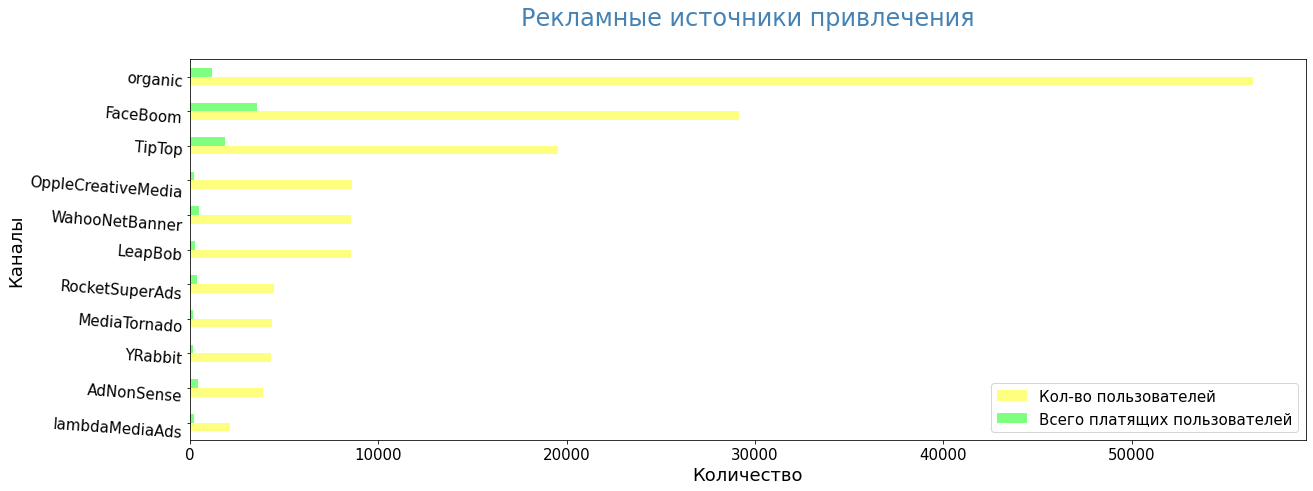

In [53]:
(
    channel_profiles[['channel', 'count_users', 'payer_users']]
    .sort_values(by='count_users')
    .plot(x='channel', kind = 'barh', figsize = (20,7), legend = True, fontsize = 15, rot=-4,
          alpha=.5, color=['#FFFF00', '#00FF00'])
    .set_title('Рекламные источники привлечения' + "\n", fontsize = 24, color = 'SteelBlue')

);

plt.ylabel('Каналы', fontsize = 18);
plt.xlabel('Количество', fontsize = 18);
plt.legend(['Кол-во пользователей', 'Всего платящих пользователей'], fontsize = 15);

Вывод:\
наибольшая доля платящих пользователей была привлечена через рекламные источники:
* FaceBoom,
* AdNonSense,
* lambdaMediaAds,
* TipTop.

Больше всего пользователей приходит через каналы:
* organic - посетители, которые попадают в приложение из результатов обычной поисковой выдачи, а не с рекламных объявлений,
* FaceBoom,
* TipTop.

Отметим, что *AdNonSense* и *lambdaMediaAds* привлекают наиболее качественных клиентов, которые в большинстве случаев становятся покупателями. Однако, они не являются лидерами по общему количеству пришедших клиентов.

**Общий вывод**
1) пользователи приходят из четырех стран:
* США - является лидером по количеству пользователей и доле платящих клиентов (6,9%),
* Великобритания,
* Франция,
* Германия.

2) Большинство пользователей используют:
* Iphone,
* Android.\
Наибольшая доля платящих клиентов приходится на пользователей устройств Mac и Iphone.

3) Общее количество рекламных источников - 10, из них лидерами по доле платящих пользователей являются:
* FaceBoom,
* AdNonSense,
* lambdaMediaAds,
* TipTop.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Общая сумма расходов на маркетинг

In [54]:
i = costs_info['costs'].sum().round()
print('Общая сумма расходов на маркетинг составляет {:.0f} у.е.'.format(i))

Общая сумма расходов на маркетинг составляет 105497 у.е.


#### Распределение трат по рекламным источникам

In [55]:
costs_info.pivot_table(index='channel', values='costs', aggfunc='sum').reset_index().sort_values(by='costs', ascending=False)

,channel,costs
6,TipTop,54751.30
1,FaceBoom,32445.60
7,WahooNetBanner,5151.00
0,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
2,LeapBob,1797.60
9,lambdaMediaAds,1557.60
3,MediaTornado,954.48
8,YRabbit,944.22


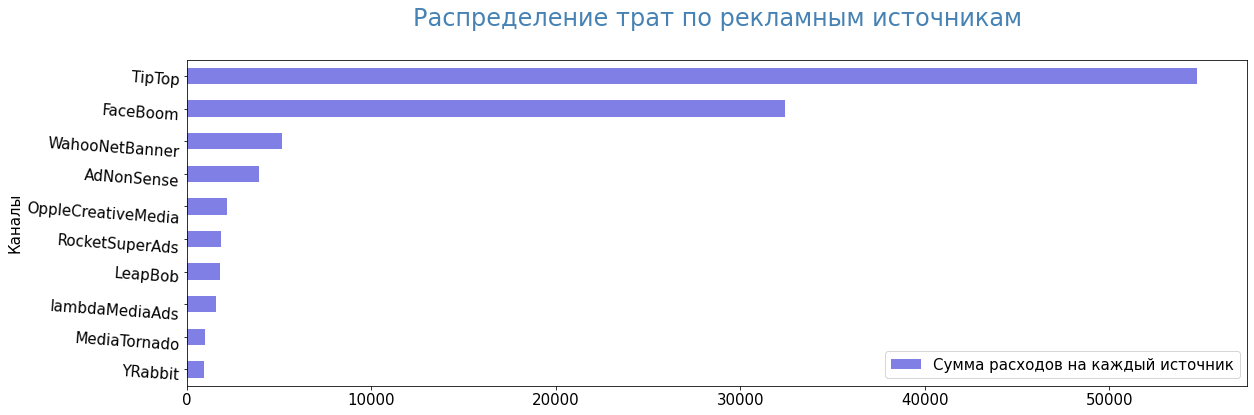

In [56]:
(
    costs_info
    .pivot_table(index='channel', values='costs', aggfunc='sum')
    .sort_values(by='costs')
    .plot(kind = 'barh', figsize = (19,6), legend = True, fontsize = 15, rot=-4,
          alpha=.5, color='#0000CD')
    .set_title('Распределение трат по рекламным источникам' + "\n", fontsize = 24, color = 'SteelBlue')
);

plt.ylabel('Каналы', fontsize = 15);
plt.legend(['Сумма расходов на каждый источник'], fontsize = 15);

Вывод:
основные расходы пришлись на рекламные источники:
* TipTop,
* FaceBoom.

Канал *FaceBoom* является лидером по привлеченю платящих клиентов (12% ). *TipTop* также являлся лидером, но его доля платящих клиентов составила лишь 9,6% (4 место в рейтинге лидеров текущего анализа). Через *FaceBoom* пришло в два раза больше  пользователей, чем *TipTop*.\
Таким образом, траты на рекламу *TipTop* почти в два раза выше, чем *FaceBoom*.


*WahooNetBanner* привлекает лишь 5% платящих пользователей (не входит в топ), в то время как расходы на рекламу по данному источнику занимают 3 место.

#### Визуализация динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [57]:
# преобразуем тип даты в datetime, чтобы в графике отображалось наименование месяца
costs_info['dt'] = costs_info['dt'].astype('datetime64[ns]')
costs_info['week'] = costs_info['dt'].dt.isocalendar().week
costs_info['month'] = costs_info['dt'].dt.month_name()

In [58]:
costs_info.head()

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,May
1,2019-05-02,FaceBoom,78.1,18,May
2,2019-05-03,FaceBoom,85.8,18,May
3,2019-05-04,FaceBoom,136.4,18,May
4,2019-05-05,FaceBoom,122.1,18,May


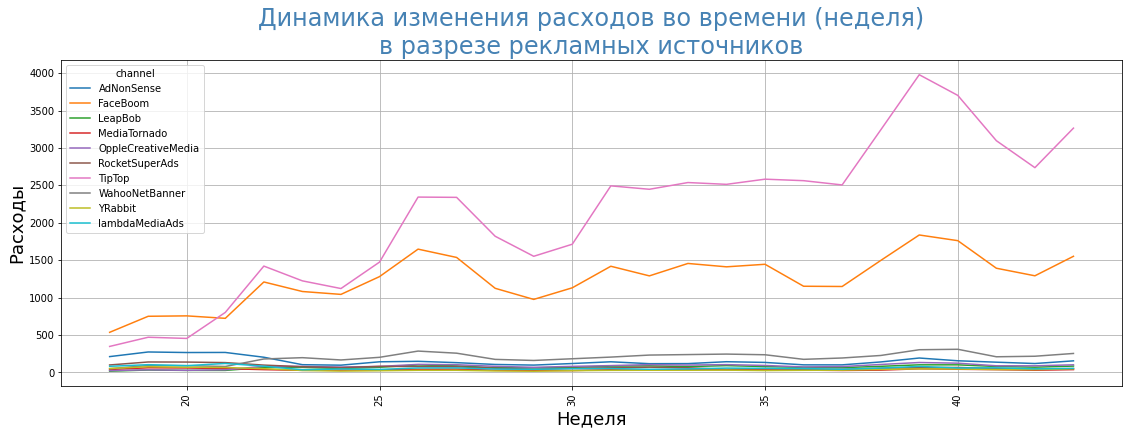

In [59]:
(
costs_info
    .pivot_table(index = 'week', columns = 'channel', values = 'costs', aggfunc = 'sum')
    .plot(grid=True, figsize=(19, 6))
    .set_title('Динамика изменения расходов во времени (неделя)' + "\n" + 'в разрезе рекламных источников', fontsize = 24, color = 'SteelBlue')
);
plt.xticks(rotation=90);
plt.ylabel('Расходы', fontsize = 18);
plt.xlabel('Неделя', fontsize = 18);

In [60]:
# вспомогательная таблица *month* для выстраивания месяцев в хронологическом порядке
month = pd.Series(['May', 'June','July','August', 'September', 'October'])
month = pd.DataFrame(month)
month.columns=['month']

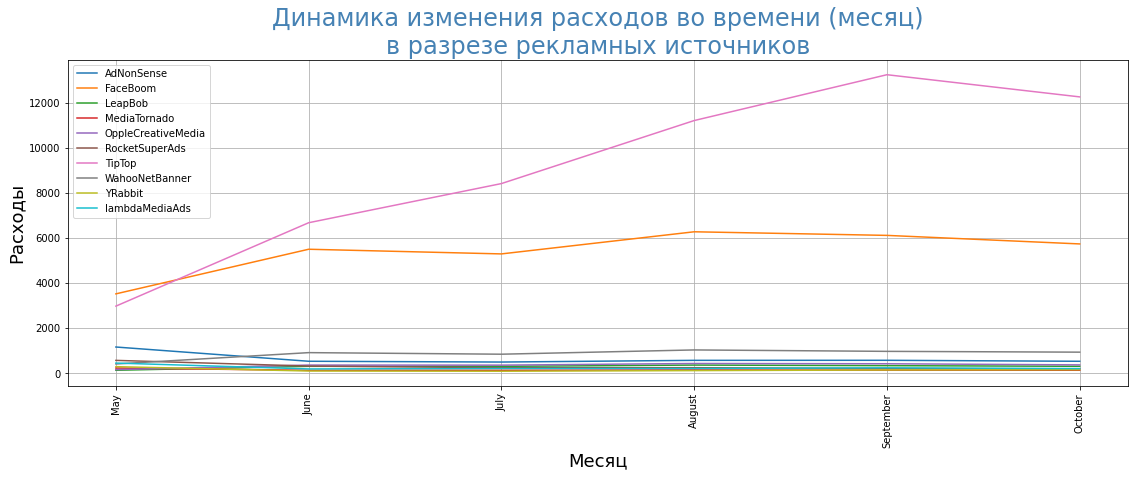

In [61]:
(
costs_info
    .pivot_table(index = 'month', columns = 'channel', values = 'costs', aggfunc = 'sum')
    .reset_index()
    .merge(month, how='right')
    .plot(x='month', grid=True, figsize=(19, 6))
    .set_title('Динамика изменения расходов во времени (месяц)' + "\n" + 'в разрезе рекламных источников', fontsize = 24, color = 'SteelBlue')
);
plt.xticks(rotation=90);
plt.ylabel('Расходы', fontsize = 18);
plt.xlabel('Месяц', fontsize = 18);

**Месяцы:**
* самым затратным для компании является рекламный источник *TipTop*\
Расходы на рекламу через данный канал стаблино растут с мая по октябрь и достигают пика в сенября (12 700 у.е.) и несущественно снижаются в октябре до 12 000 у.е.

* на втором месте траты на *FaceBoom*
Расходы расли с мая по июль, но начиная с августа стабилизировались в районе 6 тыс. у.е.\
Однако, даже после стабилизации, расходы на *FaceBoom* являются значительными по сравнению с остальными каналами.

* среди прочих каналов выделяется *WahooNetBanner*\
расходы на рекламу через данный источник стабильны(демонстрируют низкую динамику изменений от месяца к месяцу) и составляют 1000 у.е.

Таким образом, расходы на *TipTop* и *FaceBoom* в 12 раз больше(или на 90% выше), чем для остальных рекламных источников.

**Недели:**\
Наибольшие траты были по рекламным источникам:
* TipTop,
* FaceBoom.

Пик трат пришелся на 39 неделю сентября:
- расходы на TipTop составила 4000,
- расходы на FaceBoom ~ 1800.

Второй по величине пик был на 27 неделе у следующих каналов:
* TipTop - расходы около 2400 у.е.,
* FaceBoom - 1600 у.е.

В остальные каналы вкладывали существенно ниже. Среди них выделяются траты на рекламу через *WahooNetBanner* на 25 неделе и 39 неделе, а также расходы на *AdNonSense* с 18 по 20 неделю.

#### Средняя стоимость привлечения одного пользователя (CAC) из каждого источника.

Стоимость привлечения каждого посетителя отражена в столбце `acquisition_cost`.

In [62]:
cac_mean = profiles['acquisition_cost'].mean()
cac_mean
print('Средняя стоимость привлечение одного пользователя (CAC) по всем каналам составляет {:.2f} у.е.'.format(cac_mean))

Средняя стоимость привлечение одного пользователя (CAC) по всем каналам составляет 0.70 у.е.


Средняя стоимость привлечения одного пользователя (CAC) *из каждого источника*:

In [63]:
(
    profiles
    .groupby('channel')['acquisition_cost'].mean()
    .reset_index()
    .sort_values(by='acquisition_cost', ascending=False)
    .rename(columns={'acquisition_cost': 'cac_mean'})
)

#profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='mean')

,channel,cac_mean
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


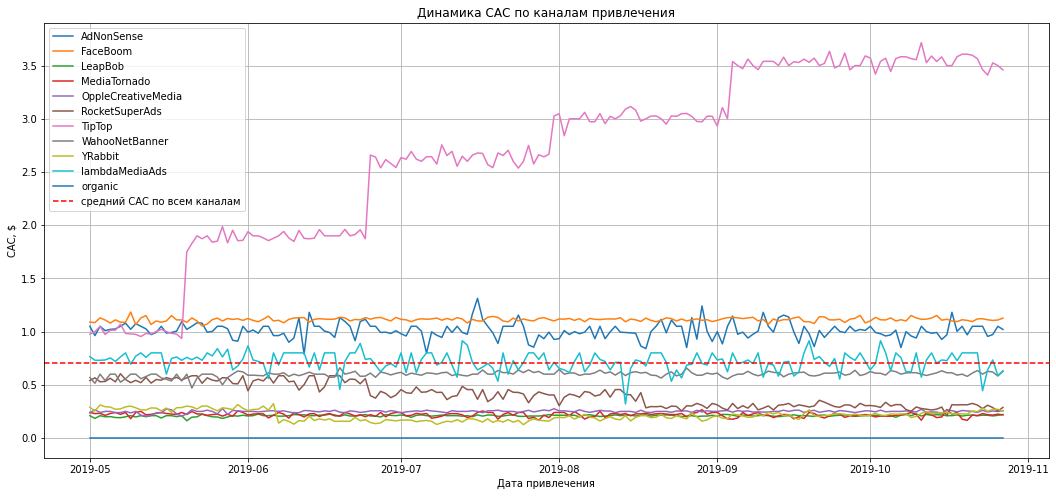

In [64]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(18, 8))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
#plt.hlines(cac_mean, 0, profiles.index.max(), linestyles='dashed')
plt.axhline(y=cac_mean, color='red', linestyle='--', label='средний CAC по всем каналам')
plt.legend()
plt.show()

Вывод:\
Для рекламного источника *TipTop* стоимость привлечения пользователя имеет восходящий тренд. В мае 2019 CAC составил 1 у.е., в ноябре 2019 = 3,5 у.е. Т.е. раходы на 1 пользователя выросли в 3 раза. Необходимо проверить LTV (есть ли он или снизился), чтобы принять решение о целесообразности трат на данный канал или разработки мер по их оптимизации.

Стоимость привлечения «органических» пользователей равна нулю, потому что они установили приложение самостоятельно, а не благодаря рекламе.

Расходы на рекламу *FaceBoom, AdNonSense, lambdaMediaAds* превышают средний CAC по всем рекламным источникам. Однако, *FaceBoom, AdNonSense, lambdaMediaAds* являются лидерами по привлечению платящих Клиентов.

**Убедимся, то стоимость привлечения клиента из таблицы ROI, умноженная на размер когорты, равна сумме рекламных трат за изучаемый период.**

In [65]:
# рассчитываем LTV и ROI

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders_info, max_analysis_date, 14
)

print(roi)  # таблица ROI 

           cohort_size       cac       0.0       1.0       2.0       3.0  \
cohort                                                                     
All users       138765  0.690417  0.348866  0.450594  0.527064  0.591669   

                4.0       5.0       6.0       7.0       8.0       9.0  \
cohort                                                                  
All users  0.648608  0.698354  0.744186  0.785358  0.825377  0.862236   

               10.0      11.0      12.0      13.0  
cohort                                             
All users  0.895801  0.927546  0.958583  0.987252  


In [66]:
max_acquisition_date = roi_history.reset_index()['dt'].max()
print(max_acquisition_date) 

2019-10-14


In [67]:
# сравниваем расходы на привлечение в таблице ROI и тратах на рекламу

print(
   'Общие расходы на привлечение из таблицы ROI: {:.2f}'.format(
       roi.loc['All users', 'cac'] * roi.loc['All users', 'cohort_size']
   )
)

print(
   'Общие расходы на привлечение из таблицы costs: {:.2f}'.format(
       costs_info.query('dt <= @max_acquisition_date')['costs'].sum()
   )
) 

Общие расходы на привлечение из таблицы ROI: 95805.74
Общие расходы на привлечение из таблицы costs: 95805.74


**Общий вывод**
- сумма расходов на маркетинг составляет 105 497 у.е.,
- наиболее затратными являются рекламные каналы:
TipTop - является одним из лидеров по привлечению платящих клиентов (их доля = 9,6%),
FaceBoom - занимает I место по привлеченю платящих клиентов (12% ),
WahooNetBanner - привлекает лишь 5% платящих пользователей, однако расходы на рекламу занимают 3 место.\
Необходимо оценить целесообразность трат на TipTop (рассчитать LTV) и, возможно, разработать меры по оптимизации расходов (если целесообразность будет подтверждена).
- для рекламного источника TipTop стоимость привлечения пользователя имеет восходящий тренд,
- расходы на рекламу FaceBoom, AdNonSense, lambdaMediaAds превышают средний CAC по всем рекламным источникам, но эти каналы являются лидерами по привлечению платящих клиентов.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

>Затраты на привлечение органических пользователей нулевые, поэтому они всегда окупаются ==> исключим их из анализа.

In [68]:
profiles_not_org = profiles.query('channel != "organic"')
profiles_not_org['channel'].unique()

array(['FaceBoom', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

#### Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI

In [69]:
observation_date = datetime(2020, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

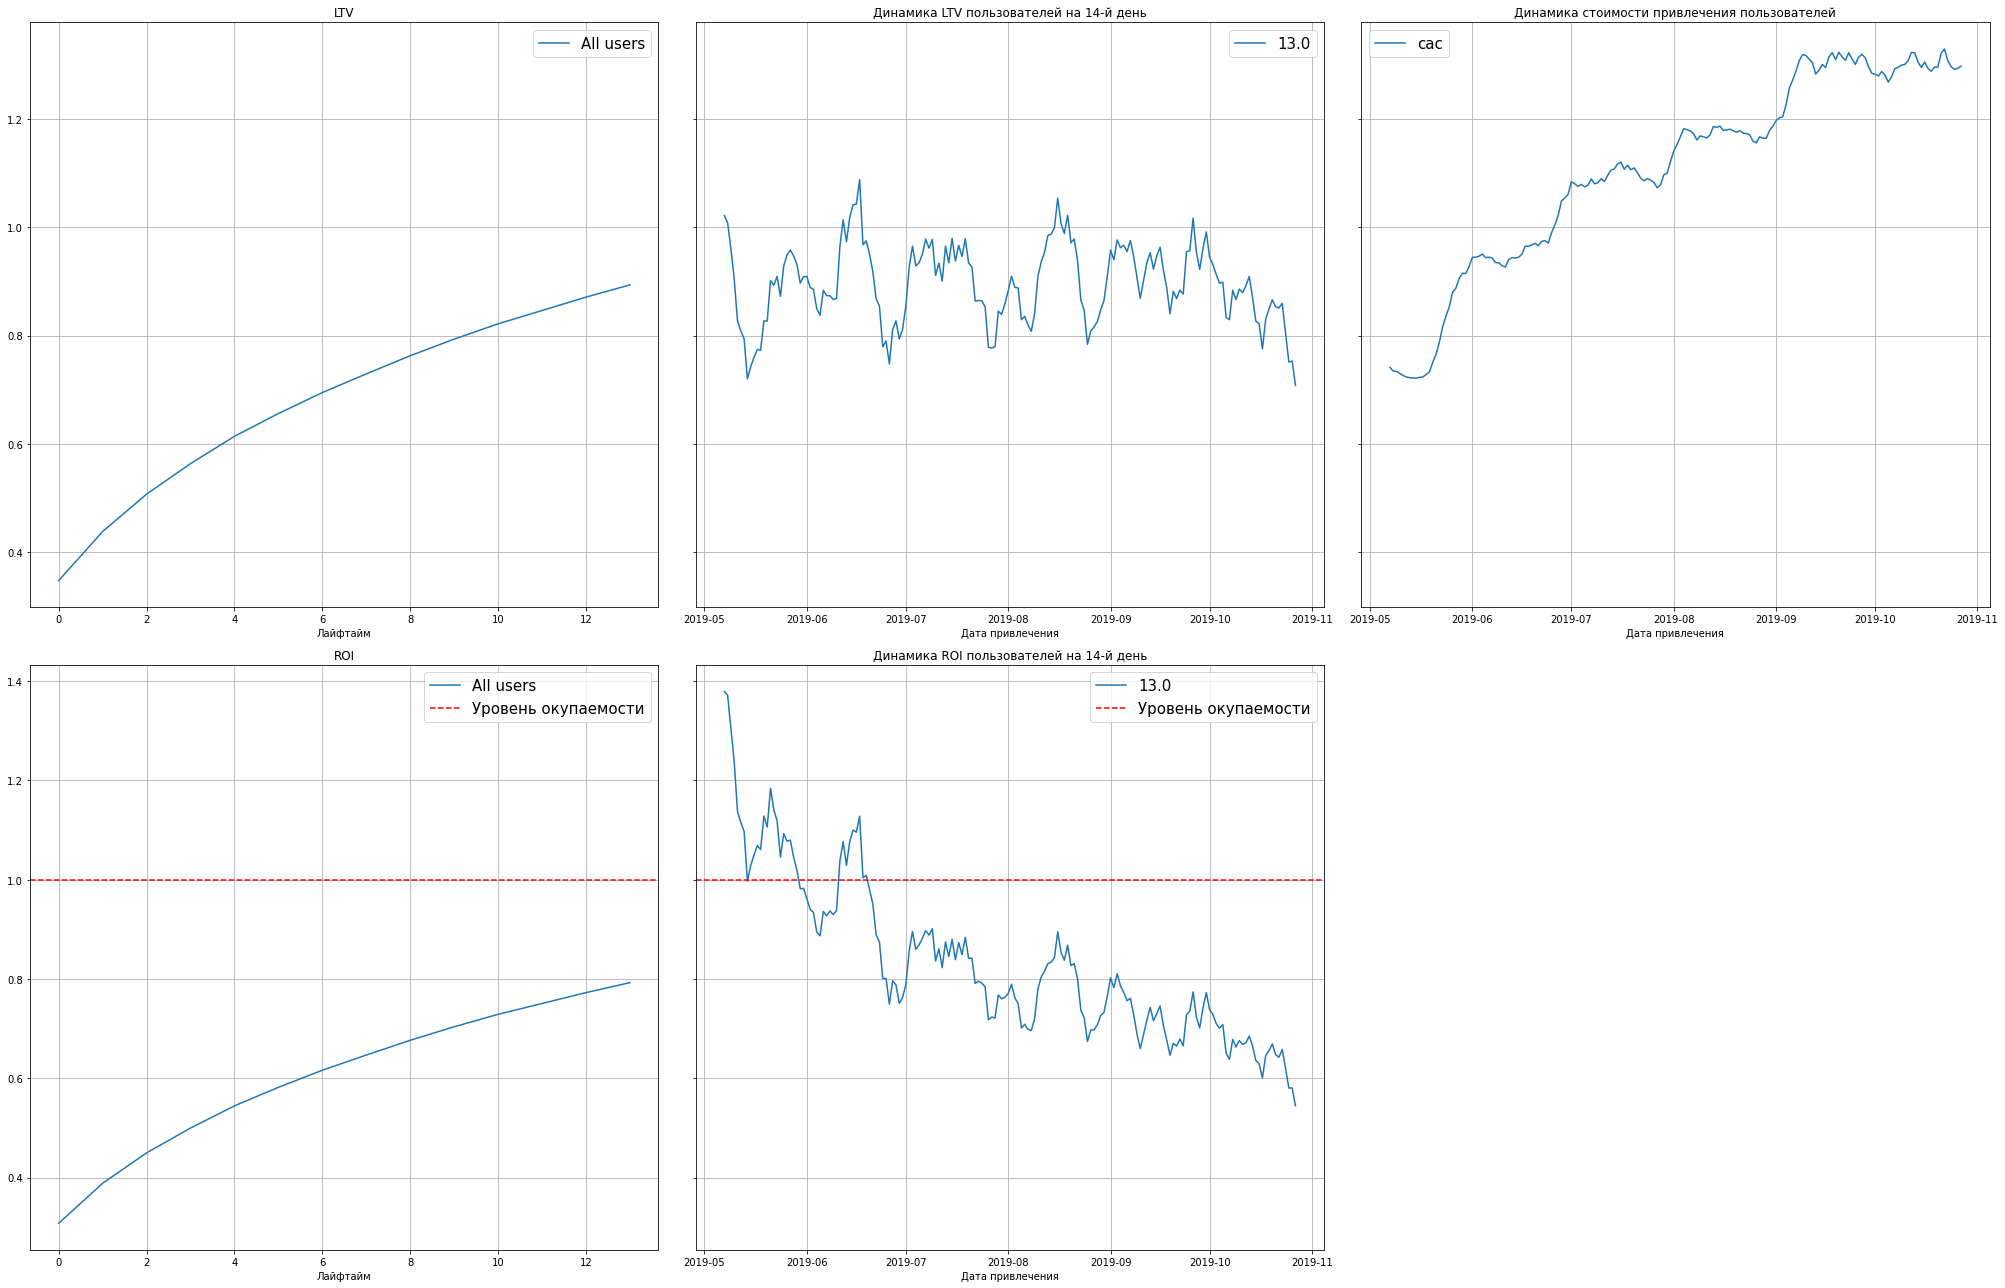

In [70]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_org, orders_info, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать выводы:\
Стоимость привлечения пользователей превшает приток денежных средств от них.\
Кривая LTV постоянно растёт ожидаемым образом. Значит, момент и горизонт анализа данных определены верно.\
На LTV достаточно стабилен. Колеблется от 0,7-1 => нет резких скачков. Значит, дело не в ухудшении качества пользователей.\
Реклама не окупается. ROI в конце второй недели — 80%. До июля реклама окупалась к 14-му дню, но были провалы на 14-й день июня. С июля динамика ROI на 14-й день уверенно снижается.\
CAC увеличивается => убытки могут быть из-за увеличения рекламного бюджета, что негативно отражается на прибыльности приложения.

Динамика ROI за лайфтайм падает. При относительно стабильной динамике LTV, динамика САС растёт с мая по конец октября. Эту закономерность мы наблюдаем в динамике ROI: при сильном увеличении САС, в равной степени падает динамика ROI пользователей.

#### Проверка конверсии (Conversion Rate) и удержания пользователей (Retention Rate) и динамики её изменения.

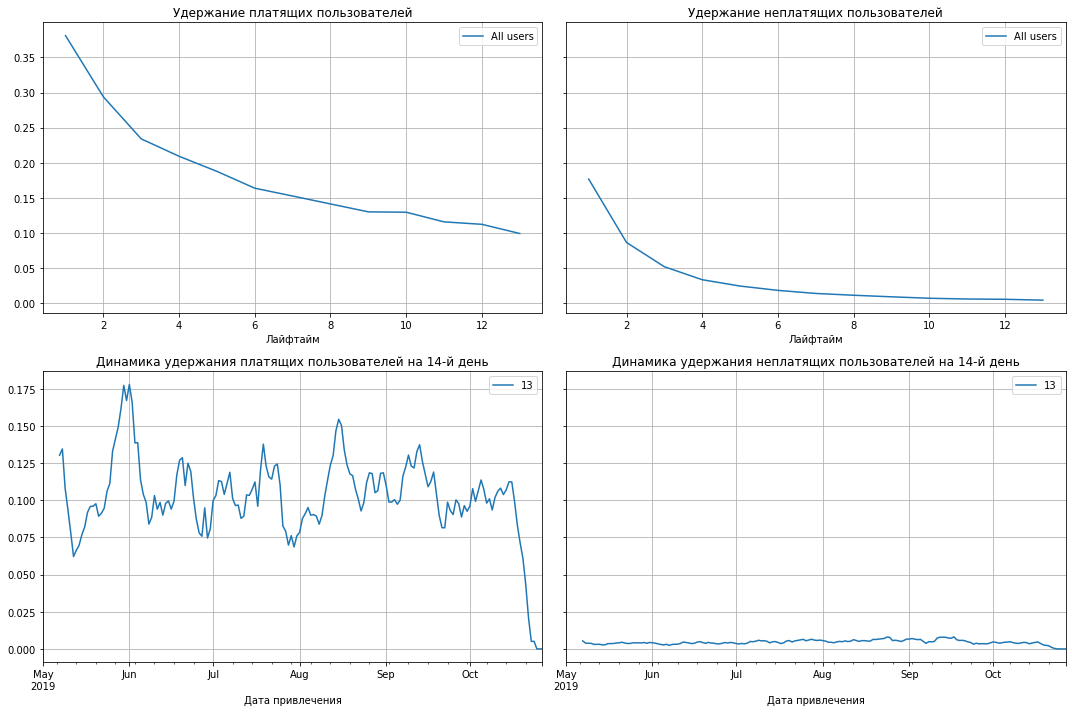

In [71]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_not_org, visits_info, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

Кривая платящих пользователей находится выше, чем кривая неплатящих.\
Форма распределений близка к обратно-экспоненциальной - в первый день жизни удержание находится на пике, а далее бесконечно приближается к нулю.\
Положительная динамика удержания на 14-й день была в июне - июле. В данный период был самый высокий показатель удержания пользователей, далее прослеживается динамика снижения. Следующий менее высокий пик обнаружен только на 14-й день в сентябре.\
После октября - удержание платящих клиентов на 14-й день стремительно спадает. Первое существенное падение было в конце второй недели июня, а затем продолжилось в октябре, а на 14- день ноября достигло нуля.

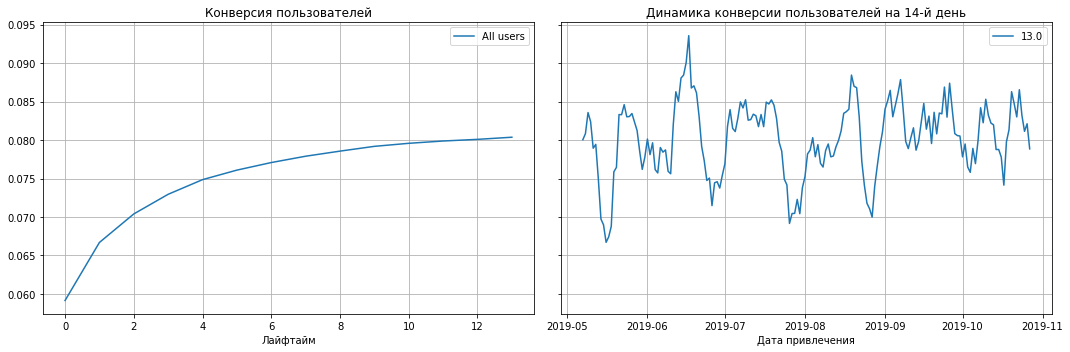

In [72]:
# смотрим конверсию 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_not_org, orders_info, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По итогам анализа графиков можем сделать вывод:\
Кривая конверсии плавно растёт от нуля в направлении единицы.\
Кривая конверсии не снижается.\
В таблице конверсии нет значений, превышающих единицу.\
Пользователи хорошо конвертировались на 14-й день в июле (пик конверсии), что соответствует периоду удержания.

#### Оценка окупаемости рекламы с разбивкой по устройствам (графики LTV и ROI, а также графики динамики LTV, CAC и ROI).

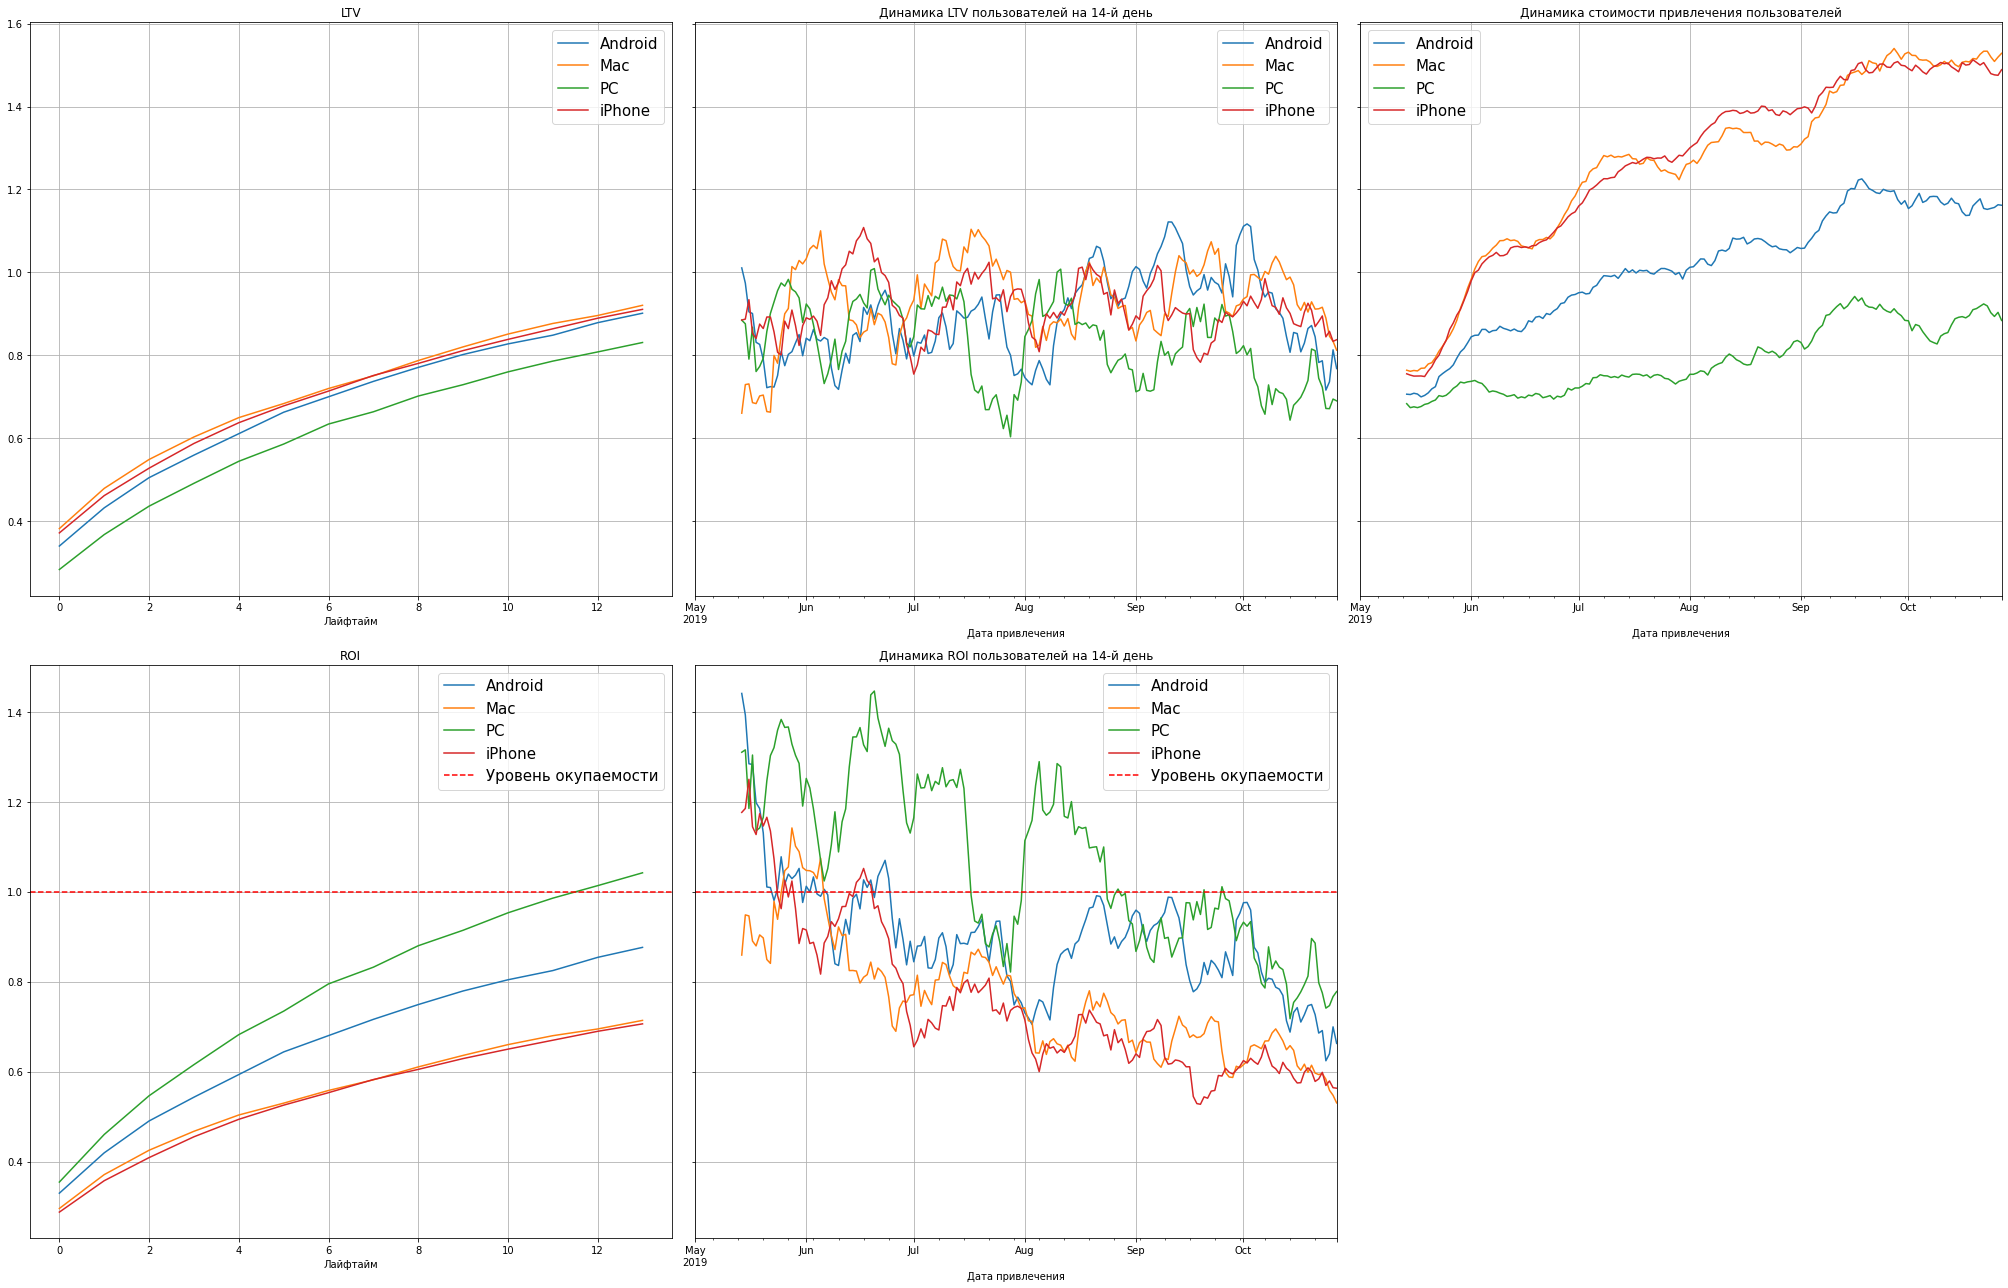

In [73]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_org, orders_info, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Вывод:
1. В аутсайдерах по LTV (приток денежных средств от пользователей) владельцы устройств **PC**, но его окупаемость существенно превышает аналогичный показатель пользователей остальных устройств.\
   Приток денежных средств от пользователей Mac и Iphone достаточно стабилен на 14-й день.
2. Самые высокие расходы на привлечение клиентов принадлежат пользователям Mac и Iphone. Траты существеннос выросли к ноябрю по сравнению с июнем (0,7 до 1,5).\
   Дешевле всего обходятся мероприятия по привлечению пользователей PC (динамика роста с 0,7 до 0,85). 
3. У всех устройст наблюдается снижение окупаемости к 14-му дню.\
   Наиболее существенное и стабильное падение ROI наблюдается у пользователей Mac и Iphone.

#### Оценка окупаемости рекламы с разбивкой по странам (графики LTV и ROI, а также графики динамики LTV, CAC и ROI).

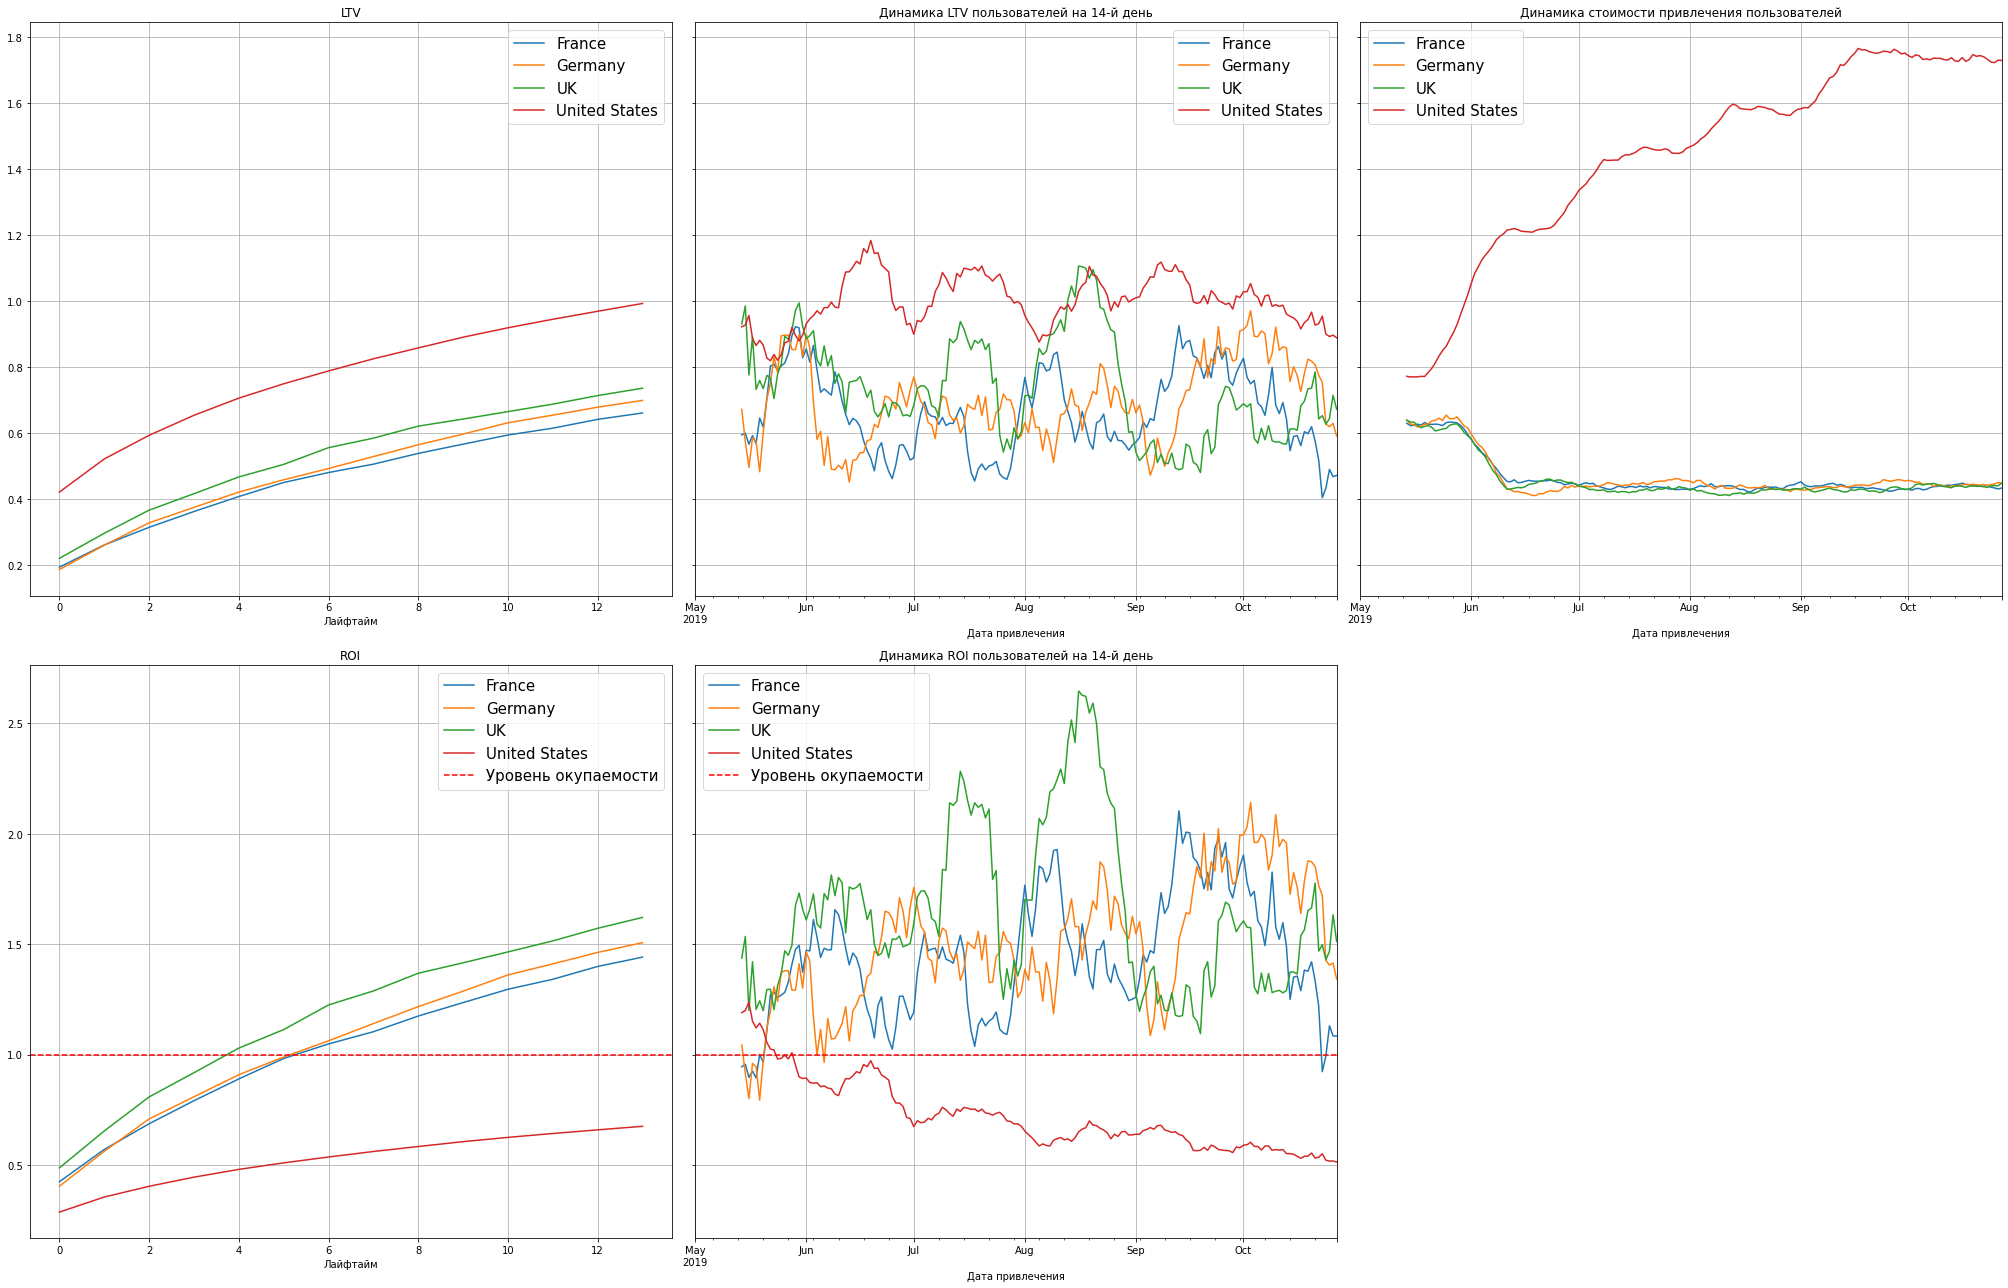

In [74]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_org, orders_info, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Вывод:
1. неокупаемой является реклама для пользователей из США. К 14-му дню уровень ROI стабильно снижается и достигает нименьшего значения в ноябре - 50%. От пользователей США стабильно "идет" приток денежных средств, он является самым высоким по сравнению с другими странами и не имеет динамики снижения в конце второй недели. Однако, рост CAC существенно превышает LTV. Расходы на рекламу США на 1 клиента выросли в два раза (с 0,8 до 1,6).
2. на 14-й день прослеживается снижение CAC во Франции, Германии и Великобритании, что положительно влияет на показатель окупаемости.
   В в конце второй недели августа - сентября на графике видим пики ROI у пользователей Великобритании. Следует отметить, что к 14-му дню октября Великобритания уступила Германии по уровню ROI.\
Таким образом, хорошую окупаемость демонстрируют пользователи Германии и Великобритании.

#### Оценка окупаемости рекламы с разбивкой по рекламным каналам (графики LTV и ROI, а также графики динамики LTV, CAC и ROI).

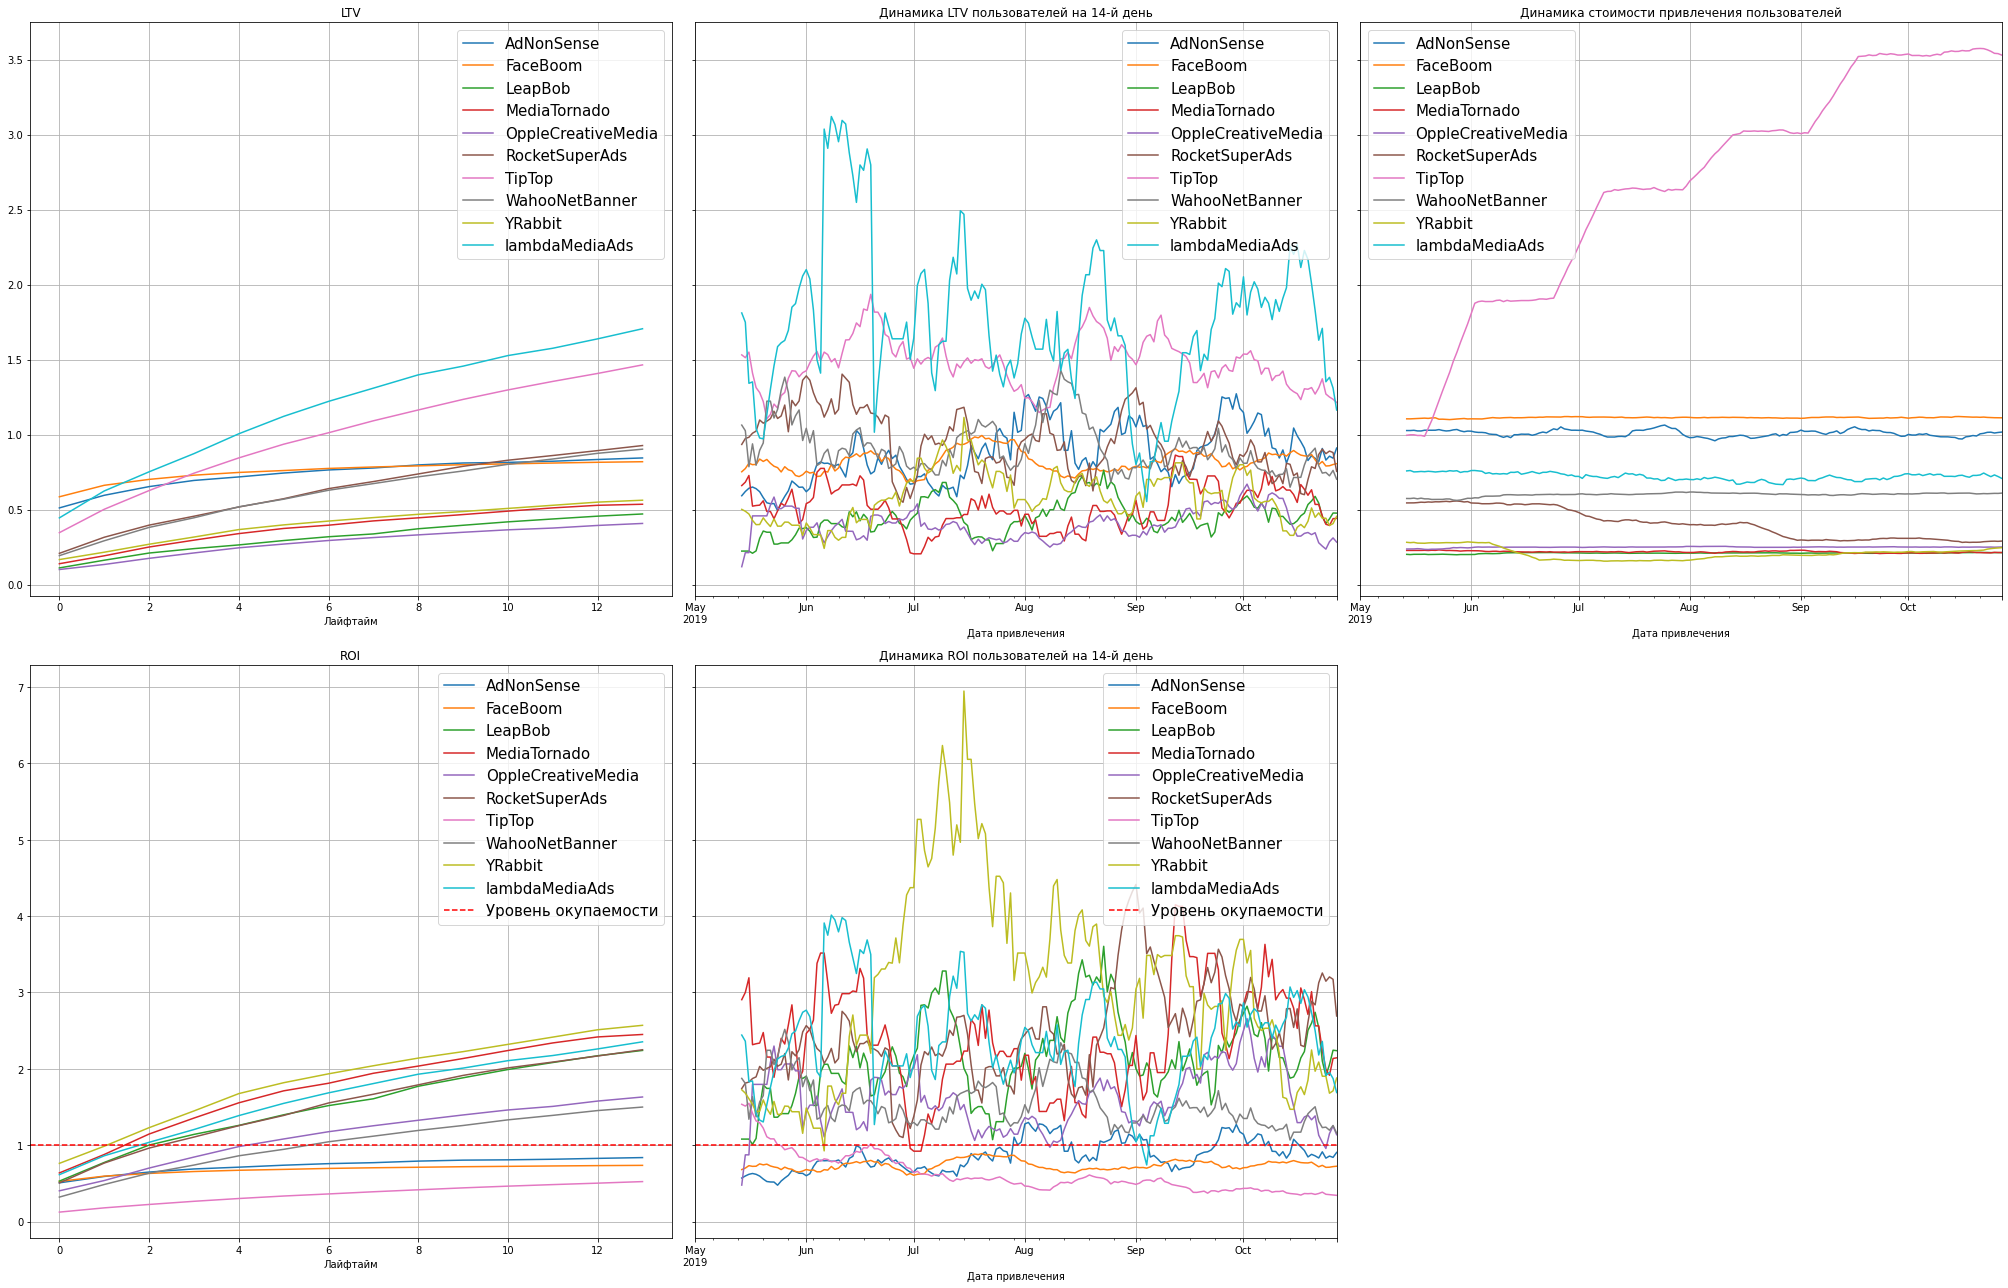

In [75]:
# смотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_org, orders_info, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

>**Негативное влияние на окупаемость рекламы оказывают:**

* *FaceBoom* занимает 1 место по количеству "пришедших" пользователей и представляет наибольшую долю привлечения платящих клиентов (12%). Показатель LTV не демонстрирует роста, динамика на 14-й день с мая по ноябрь колеблется в районе 0,8 у.е. на одного клиента. Раходы на рекламу стаблильны и превышают приток денежных средств от них (~1,3 у.е.). Динамика окупаемости на 14-й день колеблется на уровне 80% (низкая вариативность).
* *TipTip* лидирует по количеству привлеченных пользователей (2 место) и % платящих пользователей (9%).\
   Рекламный канал является лидером по затратам на привлечение 1 клиента (CAC) и имеет наименьший показатель ROI (с августа динамика на 14-й день не превышает 50%).
* *AdNonSense* также является одним из основных каналов по притоку платящих пользователей (11%). При этом показатель окупаемости на 14-й день варьируется в районе 80% - 90%. ROI превысил 100% на 14-й день только в августе и октябре.

>**Положительное влияние на окупаемость рекламы оказыают:**

* *YRabbit* привлек 3,8% платящих клиентов. Следует отметить, что канал демонстрировал самый высокий уровень ROI на 14-й день с июля по август (600%-700%), в конце второй недели ноября показатель снизился до 200%. CAC является одним из самых низких, как и показатель LTV.
* *RocketSuperAds* реклама окупается в течение всего периода с мая по ноябрь. В сентябре окупаемость достигла пика и составила 450%. Затраты на привлечение пользователя уверенно снижаются, уровень LTV на приемлимом уровне + имеет высокие показатели в динамике на 14-й день.
* *lambdaMediaAds* (доля платящих пользователей 10,5 %). Пик LTV пришелся на 14-й день июля и составил 3,2 у.е. на одного клиента. Показатель CAC стабилен и равен 0,7 у.е.\
  Пик окупаемости был в конце второй недели июля и составил 400%, на 14-й день августа пик окупаемости был равен 350%, максимальный уровень окупаемости на конец второй недели установлен в ноябре и составил 300%.
* *MediaTornado* "привел" 4 тыс. пользователей, из которых только 4% стали платящими. Динамики ROI пользователей на 14-й день занимает 3 место среди остальных рекламных источников. На 14-й день ноября данный показатель стал равен 300%.


#### Удержание пользователей с разбивкой по рекламным каналам, странам и устройствам.

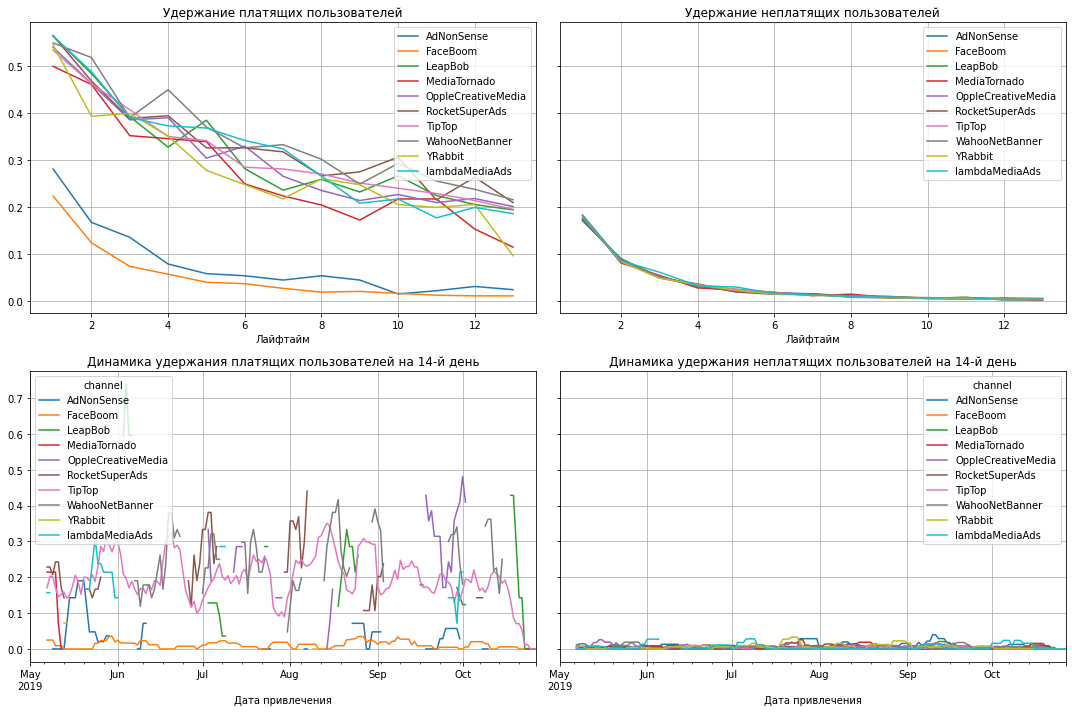

In [76]:
# смотрим удержание с разбивкой по рекламным каналам

dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_not_org, visits_info, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

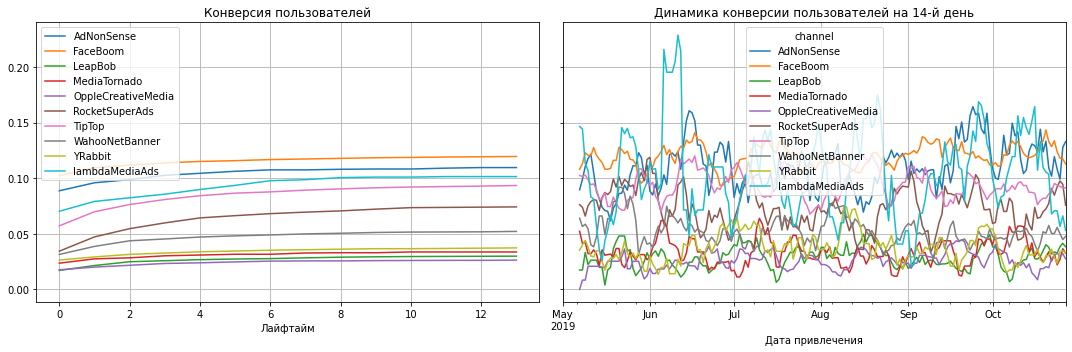

In [77]:
# смотрим конверсию с разбивкой по рекламным каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_not_org, orders_info, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

*FaceBoom*
демонстрирует самый высокий показатель конверсии, в товремя как удержание платящих пользователей является крайне слабым.\
*AdNonSense*
уровень конверсии занимает второе место по величине, но, как и в случае с FaceBoom, удержание платящих пользоателей очень слабое.

Отметим показатели конверсии и удержания на приемлемом уровне у каналов Yrabbit и RocketSuperAds.

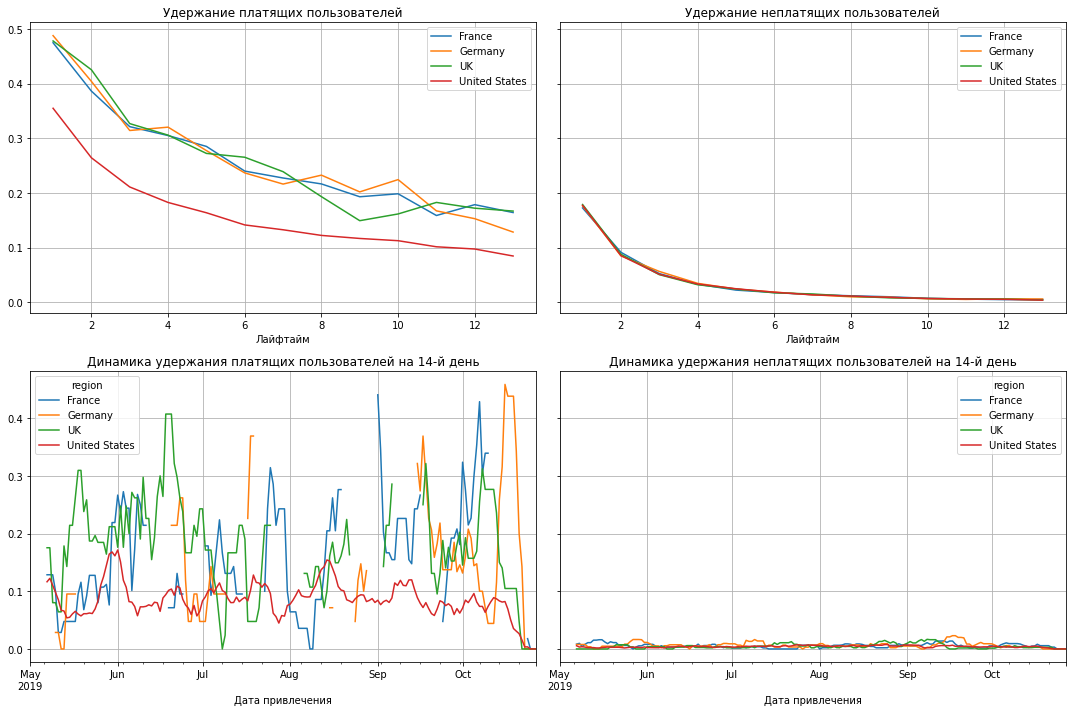

In [78]:
# смотрим удержание с разбивкой по странам

dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_not_org, visits_info, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

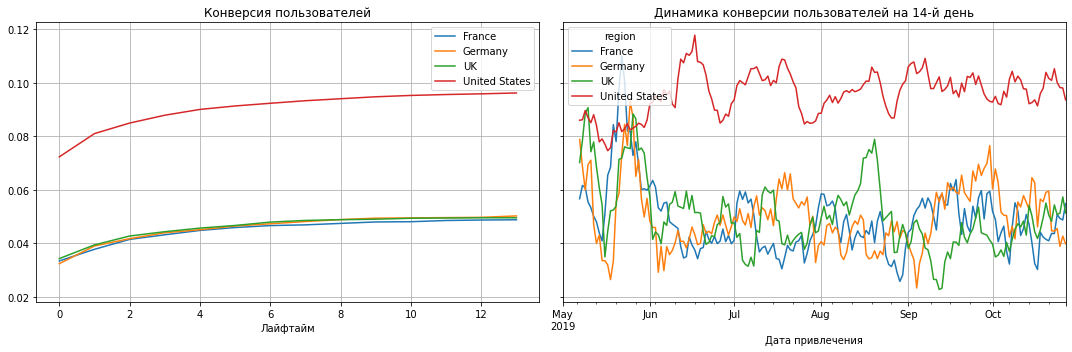

In [79]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_not_org, orders_info, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

США хуже всех остальных стран удерживает платящих пользователей, и в тоже время занимает 1 место по конверсии пользователей. Пользователи как бытро приходят, так и быстро уходят + это единственная страна, у которой не окупились расходы на рекламу.\
Наиболее хорошую конверсию и удержание  пользователей демонстрируют Германия и Великобритания.

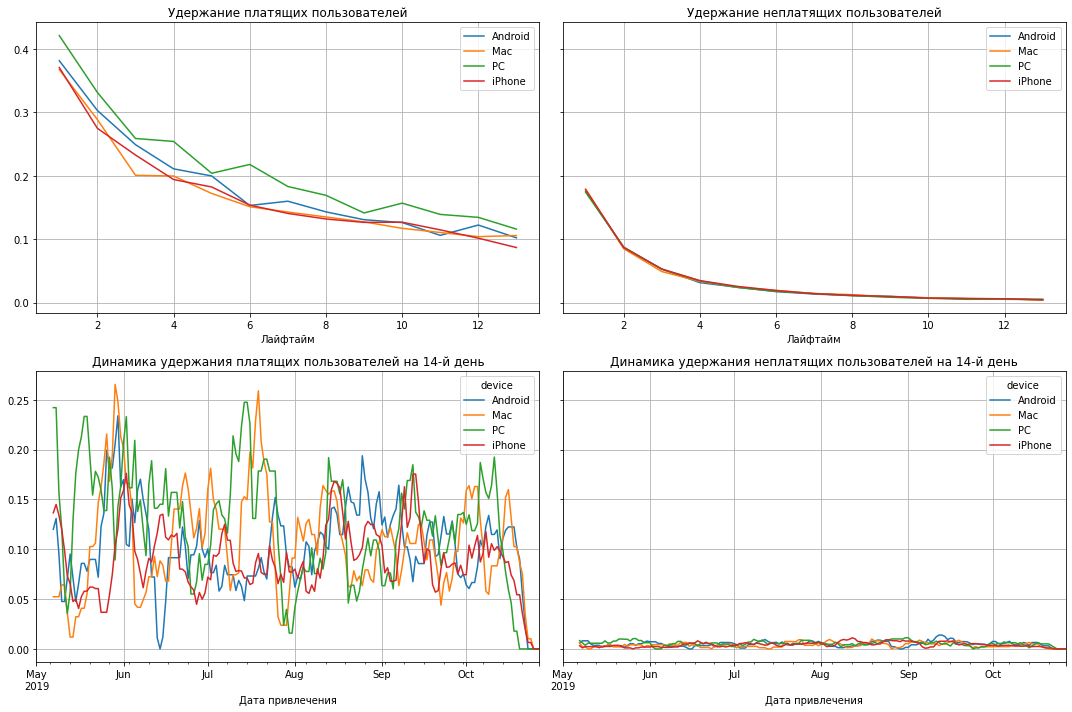

In [80]:
# смотрим удержание с разбивкой по устройствам

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_not_org, visits_info, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

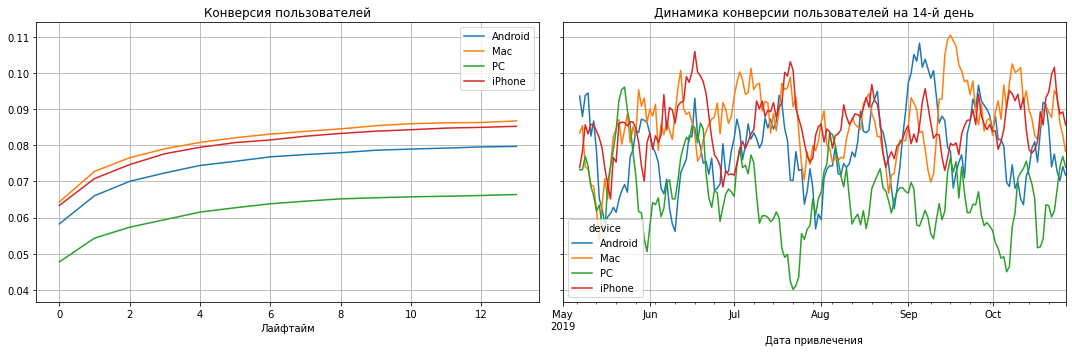

In [81]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_not_org, orders_info, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Наибольшую конверсию имеют пользователи устройств Mac, затем iPhone. В целом пользователи Apple имеют лучшую конверсию в покупателей. Третье место по уровню конверсии заняли пользователи Android. Их конверсия лишь на ~0,5% ниже, чем у пользователей устройств Apple.

**Вывод:**\
В целом реклама, направленная на привлечение пользователей, не окупается.
>**Негативное влияние на окупаемость рекламы оказывают:**

1) *Устройства:*\
Mac и Iphone - наблюдается наиболее существенное и стабильное падение ROI. При выокой конверсии, окупаемость едвали достигает 50%.

2) *Страны:*\
неокупаемой является реклама для США. Пользователи США стабильно "обеспечивают" высокий приток денежных средств по сравнению с другими странами. Однако, CAC превышает LTV. На 14-й день ноября уровень окупаемости составил 50%.\

3) *Рекламные каналы:*
* *FaceBoom* занимает 1 место по количеству "пришедших" пользователей и представляет наибольшую долю привлечения платящих клиентов (12%). Показатель LTV не демонстрирует роста, динамика на 14-й день с мая по ноябрь колеблется в районе 0,8 у.е. на одного клиента. Раходы на рекламу стаблильны и превышают приток денежных средств от них (~1,3 у.е.). Динамика окупаемости на 14-й день колеблется на уровне 80% (низкая вариативность).
* *TipTip* лидирует по количеству привлеченных пользователей (2 место) и % платящих пользователей (9%).\
   Рекламный канал является лидером по затратам на привлечение 1 клиента (CAC) и имеет наименьший показатель ROI (с августа динамика на 14-й день не превышает 50%).
* *AdNonSense* также является одним из основных каналов по притоку платящих пользователей (11%). При этом показатель окупаемости на 14-й день варьируется в районе 80% - 90%. ROI превысил 100% на 14-й день только в августе и октябре.

>**Положительное влияние на окупаемость рекламы оказыают:**

1) *Устройства:*\
PC - пользователи данных устройств демонстрировали самый высокий ROI. Пик показателя был в конце второй недели июля и составил 140%, но динамика показателя на 14-й день снизилась в ноябре до 80%. Показатель окупаемости на 14-й имеет динамику снижения. Но даже при такой динамике ROI был самым высоким среди пользователей остальных устройств.
Android обладает хорошей конверсией и удержанием платящих пользователей. При возможности снижения расходов на привлечение 1 пользователя, пользователи данных устройств могут оказать положительное влияние на окупаемость рекламы.

2) *Страны:*\
хорошую окупаемость демонстрируют пользователи Германии и Великобритании.

3) *Рекламные каналы:*
* *YRabbit* привлек 3,8% платящих клиентов. Следует отметить, что канал демонстрировал самый высокий уровень ROI на 14-й день с июля по август (600%-700%), в конце второй недели ноября показатель снизился до 200%. CAC является одним из самых низких, как и показатель LTV.
* *lambdaMediaAds* (доля платящих пользователей 10,5 %). Пик LTV пришелся на 14-й день июля и составил 3,2 у.е. на одного клиента. Показатель CAC стабилен и равен 0,7 у.е.\
  Пик окупаемости был в конце второй недели июля и составил 400%, на 14-й день августа пик окупаемости был равен 350%, максимальный уровень окупаемости на конец второй недели установлен в ноябре и составил 300%.
* *MediaTornado* "привел" 4 тыс. пользователей, из которых только 4% стали платящими. Динамики ROI пользователей на 14-й день занимает 3 место среди остальных рекламных источников. На 14-й день ноября данный показатель стал равен 300%.

Проблемы окупаемости могут быть вызваны чрезмерными расходами на привлечение пользователей из США и рекламные источники TipTop, FaceBoom. При высокой конверсии FaceBoom, окупаемость с трудом достигает 80%, аналогичная ситуация у пользователей, которые пришли от TipTop.\
Как пользователи США, так и каналы TipTop и FaceBoom не окупаются, что приводит к получению компанией убытоков от огромных вложений в рекламу развлекательного приложения Procrastinate Pro+.

>**Рекомендации:**

-уменьшить расходы на неокупаемые рекламные источники: TipTop, FaceBoom и AdNonSense.\
Удержание платящих пользователей от FaceBoom и AdNonSense к 8 дню лайфтайма снижается практически до нуля. Динамика удержания платящих пользователей на 14-й день у FaceBoom является худшей и не превышает 0,05.\
-снизить траты на привлечение пользователей США и рассмотреть в качестве основных пользователей их других стран.
-составить план мероприятий по увеличению числа пользователей устройств PC и Android.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

**Причины неэффективности привлечения пользователей:**
1. перманентный рост затрат на привлечение пользователей из США. В то время как это единественная страна, у которой расходы на привлечение пользователей не окупаются за две недели. В остальных странах расходы на рекламу начинают окупаться на 3-й день,
2. не целесообразность расходов на пользователей Mac и Iphone:\
   основные пользователя Iphone  - жители США => окупаемость рекламы на устройствах Iphone низкая.
   окупаемость равна 50%, а расходы на привлечение пользователей - самые высокие 16 у.е. на 1 клиента. Для пользователей Android и PC едва ли достигает 12 у.е.,
3. огромные раходы на рекламные каналы, которые не приносят достаточного дохода: TipTop, FaceBoom и AdNonSense. Компания несет существенные расходы на рекламу в TipTop, при этом окупаемость рекламы едва ли достигает 50%. Показатель удержания платящих пользователей у данных рекламных источников является самым низким.

**Рекомендации для отдела маркетинга:**
1. проанализировать наличие ресурсов для увеличения спроса на приложение Procrastinate Pro+ в Германии и Великобритании. Эти страны показали хорошую окупаемость,
2. увеличить приоритет для пользователей PC. Оценить возможность сокращения расходов на привлечение пользователей устройств Android. Реклама, направленная на привлечение пользователей приложения, хорошо окупается у Android. Пользователи этого устройства могут оказать положительное влияние на окупаемость рекламы в будущем,
3. проверить работоспособность приложения на устройствах Mac и Iphone, т.к. удержание 3-го дня ниже, чем на остальных устройствах, примерно на 10%-15%,
4. снизить рекламный бюджет для пользователей США,
5. улучшить качество пользователей "пришедших" через *FaceBoom*. Среди других рекламных источников через FaceBoom "пришло" самое бльшое количество пользователей, высокий процент которых конвертировались в платящих (12%). Считаем неразумным терять такое большое количество пользователей с хорошей конверсией.\
    Привлечение новых клиентов обходится в разы дороже, чем удержание существующих. Необходимо поработать с удержанием.
6. исключить расходы на рекламу через TipTop. По итогам исследования выявлено высокое негативное влияние на окупаемость рекламы через данный канал. Полагаем, что канал привлекает неверную аудиторию, для которой приложение является малопривлекательным/неинтересным.\
   Отказываясь от TipTop, предлагаем сместить фокус на каналы RocketSuperAds.\
   RocketSuperAds имеет неплохие результаты: реклама окупается в течение всего периода с мая по ноябрь. Затраты на привлечение пользователя уверенно снижаются. Уровень LTV имеет высокие показатели в динамике на 14-й день.

*Дополнительная информация:*\
    Не рекомендуем вкладываться в канал `Yrabbit`.\
Через канал YRabbit приходят качественные пользователи, которые неплохо конверируются. Канал демонстрировал самый высокий уровень ROI на 14-й день (600% июль-700% август). CAC является одним из самых низких.

*Обоснование отказа от вложений:* да, канал сейчас окупается, потому что там низкий CAC. Фактически компания сейчас сильно много не платит за новых клиентов (CAC = 0,21) . И уже на этих клиентах (которые обошлись недорого) мы сможем спрогнозировать будущую картину. КЛиенты имеют низкую конвертируемость и сильно падающее удержание на последних днях горизонта.

*Вывод:* пользователям Yrabbit не интересно приложение Procrastinate Pro+. Возможно, это просто не наша аудитория.